# Open-Loop Coherent Compressed Sensor (OL-CCS)

Author: M. D. Sudeera H. Gunathilaka

Release version     : 1.2 <br>
Creation date       : 2023/12/03 M. D. Sudeera H. Gunathilaka <br>

Github: https://github.com/SuhiG





# 1) Description

## Introduction

Compressed sensing (CS) is a method of reconstructing a high-dimensional signal or image based on highly downsampled measurements.

The Coherent Compressed Sensor (CCS) is designed to solve the problem of $l_0$-Regularised Compressed Sensing, which is a combinatorial optimisation problem. 

## Model

The problem Hamiltonian can be stated as follows.

$$ H = \sum_{r<r'}^{N}\sum_{k = 1}^{M} A_{r}^{k}A_{r'}^{k}R_{r}R_{r'}\sigma_{r}\sigma_{r'} - \sum_{r=1}^{N}\sum_{k =1}^{M} y^{k}A_{r}^{k}R_{r}\sigma_{r} + {\lambda} \sum_{r = 1}^{N} \sigma_r .$$

The above equation shows an observed signal $y \in \mathbb{R}^M$ and an observation matrix $A \in \mathbb{R}^{M\times N}$. The term $R \in \mathbb{R}^N$ and $\sigma \in \left\{{0,1}\right\}^N$ correspond to the source signal and support vector, respectively.
In this case, the quadratic optimisation part of the problem (signal - $R_{r}$) is done by using the Classical Digital Processor (CDP) while the combinatorial optimisation part of the problem (support - $\sigma_{r}$) is performed by the CIM in alternate steps.

For the CIM, the injection and local fields can be specified as follows.

$$    \left(\dfrac{dc_{r}}{dt}\right)_{inj,r} = \left(|h_r| - \eta\right). $$

$$h_{r} = -{\sum_{r' = 1 (\neq r)}^{N}\sum_{k = 1}^{M}} A_r^k A_{r'}^k R_{r'}H(c_{r'}) + \sum_{k=1}^M A_{r}^k y^{k} . $$

$H(c_r)$ is the binarised in-phase amplitude by the Heaviside step function. $\eta$ is the threshold which is related to the $l_0$-regularisation parameter $\lambda$ by $\eta = \sqrt{2\lambda}$ according to the Maxwell rule.
Open-Loop CCS is composed of the following stochastic differential equations.

$$
        \frac{d}{dt}c_r = \left[-1 + p - {\left(c_r^2 + s_r^2\right)} \right]c_r + \widetilde{K}\left(\dfrac{dc_{r}}{dt}\right)_{inj,r} + {g^2}\sqrt{\left(c_r^2 + s_r^2\right) + \frac{1}{2}} W_{r,1},$$


$$\frac{d}{dt}s_r = \left[-1 - p - {\left(c_r^2 + s_r^2\right)}\right]s_r + {g^2}\sqrt{\left(c_r^2 + s_r^2\right) + \frac{1}{2}} W_{r,2} .
$$

Here, in-phase and quadrature-phase normalised amplitudes are represented as $c_r$ and $s_r$ respectively. $p$ is the normalised pump rate. $W_{r,1}$ and $W_{r,2}$ are independent real Gaussian noise processes. The term ${g^2}$ indicates the saturation parameter while $\widetilde{K}$ indicates the normalised feedback strength. 

In the CDP, we solve the following system of equations using the Jacobi method.

$$ R_{r}\sum_{k = 1}^{M} \left(A_{r}^{k}\right)^2 = \sigma_{r}\mathbb{H}_{r}, $$


$$ \mathbb{H}_{r} = -\sum_{r' = 1 (\neq r)}^{N}\sum_{k = 1}^{M} A_{r}^{k}A_{r'}^{k}R_{r'}\sigma_{r'} + \sum_{k =1}^{M} A_{r}^{k}y^{k} .$$


## Pseudo-code

    FOR rep IN 0:reps
        FOR t IN 0:tmax
            Set h_i to J*(rCDP*sigCIM) + hz                      #Matrix-Vector multiplication
            Set c to c + (-(1 - p + c**2 + s**2)*c + JJ * (abs(h_i) - eta) + g * sqrt(c**2 + s**2 + 0.5) * w1)*dt
            Set s to s + (-(1 + p + c**2 + s**2)*s + g * sqrt(c**2 + s**2 + 0.5) * w2)*dt
            Set sigCIM to ((c/abs(c))+1)/2
        END FOR
        FOR tt IN 0:ttmax
            Set hCDP to J*(rCDP*sigCIM) + hz                     #Matrix-Vector multiplication
            Set rCDP to rCDP + (-rCDP + hCDP)*dt1
        END FOR
    END FOR

## Benchmark

OL-CCS performance is evaluated for randomly generated CS problem instances. The performance accuracy is evaluated by calculating the Root-Mean-Squared-Error (RMSE) as $$ \sqrt{\dfrac{1}{N} \sum_{r=1}^N \left(R_r\sigma_r - x_r\xi_r\right)^2}, $$

where $R_r$ and $\sigma_r$ is the estimated signal and support from OL-CCS and $x_r$ and $\xi_r$ is the correct signal and support for the CS problem instance. 

## References

[1]. T. Aonishi, K. Mimura, M. Okada, and Y. Yamamoto, “L0 regularization based compressed sensing with quantum–classical hybrid approach,” Quantum Science and Technology 7, 035013 (2022)

[2]. M. D. S. H. Gunathilaka, S. Kako, Y. Inui, K. Mimura, M. Okada, Y. Yamamoto, and T. Aonishi, “Effective implementation of L0-regularised compressed sensing with chaotic-amplitude-controlled coherent ising machines,” Scientific Reports 13, 16140 (2023).

# 2) OL-CCS on Random CS problem instances

In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import mean
from numpy import genfromtxt

In [2]:
N = 2000 # System size (N)
M = 1200 # Compressed size (N*compression ratio - This case 2000*0.6=1200)
K = 1
sparseness = 0.2 # Ratio of non-zero elemnts in the initial vector
probs = 10 # Number of problems
rmseArr = []

stt = time.time()
for pp in range(probs):
    
    torch.manual_seed(pp+123)
    AA = torch.normal(mean=0, std=1, size=(M,N), dtype=torch.double) # Observation matix
    AA = AA/math.sqrt(M)
    signal = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double) # Signal (Continuous)
    support = torch.ones(N, dtype=torch.double) # Support (Binary)

    # Creating a sparse Support according to the sparseness ratio
    for i in range(N):
        if (i <= int(sparseness * N)):
            support[i] = 1.0
        else:
            support[i] = 0.0
            
    nu = 0.0
    obNoise = torch.normal(mean=0, std=0.1, size=(M,), dtype=torch.double) # Observation noise
    y = torch.matmul(AA, signal * support) + nu * obNoise # Observation signal
    A_norm = torch.zeros(N, dtype=torch.double)

    # Norm of the observation matrix
    for i in range(N):
        A_norm[i] = 0
        for j in range(M):
            A_norm[i] += AA[j][i] * AA[j][i]
        A_norm[i] = torch.sqrt(A_norm[i])

    J = torch.zeros((N,N), dtype=torch.double)
    hz = torch.zeros(N, dtype=torch.double)


    J = torch.matmul((AA/A_norm).T, AA/A_norm) # Coupling matrix
    J.fill_diagonal_(0)
    J = -J
    hz = torch.matmul((AA/A_norm).T, y) # Zeeman term

    eta_int = 0.6 # Starting L0-Regularisation parameter
    eta_end = 0.01 # Starting L0-Regularisation parameter
    REP = 50 # Number of alternating minimisation processes
    JJ = 0.25 # Feedback strength
    Tmax = 5 # Max-time for CIM
    dt = 0.1 # Time-step for CIM
    dt1 = 0.1 # Time-step for CDP
    RTmax = 10 # Max-time for CDP
    g = 1e-7 # Saturation parameter 
    Pmax = 1.5 # Max Pump rate

    sigCIM = torch.zeros(N, dtype=torch.double)
    rCDP = torch.zeros(N, dtype=torch.double)

    for ll in range(REP+1):
        eta = max(eta_int * (1 - (ll/REP)), eta_end) # L0-Regularisation parameter schedulling

        sigCIM = torch.zeros(N, dtype=torch.double)
        c = torch.zeros(N, dtype=torch.double)
        s = torch.zeros(N, dtype=torch.double)
        rr = torch.zeros(N, dtype=torch.double)

        for kk in range(round(Tmax/dt)):
            tmp = kk*dt/Tmax
            pump = tmp*tmp*Pmax # Pump rate schedulling

            # Injection field Calculation
            out = rCDP*sigCIM
            Zeeman = hz
            h_i = torch.matmul(J,out) + Zeeman

            # OL-CCS SDEs 
            w1 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double)
            w2 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double)
            rr = torch.pow(c,2) + torch.pow(s,2)
            c =  c + ((-1 + pump - rr) * c + JJ * (torch.abs(h_i) - eta)) * dt + math.sqrt(dt) * torch.sqrt(rr + 0.5) * g * w1
            s =  s + ((-1 - pump - rr) * s) * dt + math.sqrt(dt) * torch.sqrt(rr + 0.5) * g * w2
            sigCIM = ((torch.div(c, torch.abs(c))+1)/2) # Support estimation
        
        # Jacobi method for Signal optimisation
        for rr in np.arange(0.0,RTmax/dt1,1.0):

            hCDP = torch.matmul(J,(rCDP*sigCIM)) + hz
            rCDP = rCDP + (-rCDP + hCDP)*dt1

    # Evaluation by Root-Mean-Squared-Error (RMSE)
    rmse = torch.sqrt(1/N * torch.sum(torch.pow(torch.sub((sigCIM * rCDP)/A_norm, signal * support),2)))
    rmseArr.append(rmse.detach().cpu().numpy())
    print("Problem = "+ "{:.0f}".format(pp) +" | "+ " RMSE = "+ "{:.6f}".format(rmse))

print(time.time() - stt, "s")
print("==> N = "+ str(N) + ", M = "+ str(M) + " | Problems = "+ "{:.0f}".format(probs) +" | "+ " average RMSE = "+ "{:.6f}".format(sum(rmseArr)/probs))


Problem = 0 |  RMSE = 0.000360
Problem = 1 |  RMSE = 0.000799
Problem = 2 |  RMSE = 0.000660
Problem = 3 |  RMSE = 0.000521
Problem = 4 |  RMSE = 0.000683
Problem = 5 |  RMSE = 0.000611
Problem = 6 |  RMSE = 0.000267
Problem = 7 |  RMSE = 0.000119
Problem = 8 |  RMSE = 0.000784
Problem = 9 |  RMSE = 0.000874
410.2565498352051 s
==> N = 2000, M = 1200 | Problems = 10 |  average RMSE = 0.000568


# 3) OL-CCS on Random CS problem instances with observation noise

In [3]:
N = 2000 # System size (N)
M = 1600 # Compressed size (N*compression ratio - This case 2000*0.6=1600)
K = 1
probs = 10 # Number of problems
rmseArrALL = []

stt = time.time()
for iters in range(15):
    rmseArr = []
    sparseness = 0.01+0.01*iters # Ratio of non-zero elemnts in the initial vector
    for pp in range(probs):

        torch.manual_seed(pp+123)
        AA = torch.normal(mean=0, std=1, size=(M,N), dtype=torch.double) # Observation matix
        AA = AA/math.sqrt(M)
        signal = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double) # Signal (Continuous)
        support = torch.ones(N, dtype=torch.double) # Support (Binary)

        # Creating a sparse Support according to the sparseness ratio
        for i in range(N):
            if (i <= int(sparseness * N)):
                support[i] = 1.0
            else:
                support[i] = 0.0

        nu = 1.0
        obNoise = torch.normal(mean=0, std=0.1, size=(M,), dtype=torch.double) # Observation noise
        y = torch.matmul(AA, signal * support) + nu * obNoise # Observation signal
        A_norm = torch.zeros(N, dtype=torch.double)

        # Norm of the observation matrix
        for i in range(N):
            A_norm[i] = 0
            for j in range(M):
                A_norm[i] += AA[j][i] * AA[j][i]
            A_norm[i] = torch.sqrt(A_norm[i])

        J = torch.zeros((N,N), dtype=torch.double)
        hz = torch.zeros(N, dtype=torch.double)


        J = torch.matmul((AA/A_norm).T, AA/A_norm) # Coupling matrix
        J.fill_diagonal_(0)
        J = -J
        hz = torch.matmul((AA/A_norm).T, y) # Zeeman term

        eta_int = 0.6 # Starting L0-Regularisation parameter
        eta_end = 0.35 # Starting L0-Regularisation parameter
        REP = 50 # Number of alternating minimisation processes
        JJ = 0.25 # Feedback strength
        Tmax = 5 # Max-time for CIM
        dt = 0.1 # Time-step for CIM
        dt1 = 0.1 # Time-step for CDP
        RTmax = 10 # Max-time for CDP
        g = 1e-7 # Saturation parameter 
        Pmax = 1.5 # Max Pump rate

        sigCIM = torch.zeros(N, dtype=torch.double)
        rCDP = torch.zeros(N, dtype=torch.double)

        for ll in range(REP+1):
            eta = max(eta_int * (1 - (ll/REP)), eta_end) # L0-Regularisation parameter schedulling

            sigCIM = torch.zeros(N, dtype=torch.double)
            c = torch.zeros(N, dtype=torch.double)
            s = torch.zeros(N, dtype=torch.double)
            rr = torch.zeros(N, dtype=torch.double)

            for kk in range(round(Tmax/dt)):
                tmp = kk*dt/Tmax
                pump = tmp*tmp*Pmax # Pump rate schedulling

                # Injection field Calculation
                out = rCDP*sigCIM
                Zeeman = hz
                h_i = torch.matmul(J,out) + Zeeman

                # OL-CCS SDEs 
                w1 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double)
                w2 = torch.normal(mean=0, std=1, size=(N,), dtype=torch.double)
                rr = torch.pow(c,2) + torch.pow(s,2)
                c =  c + ((-1 + pump - rr) * c + JJ * (torch.abs(h_i) - eta)) * dt + math.sqrt(dt) * torch.sqrt(rr + 0.5) * g * w1
                s =  s + ((-1 - pump - rr) * s) * dt + math.sqrt(dt) * torch.sqrt(rr + 0.5) * g * w2
                sigCIM = ((torch.div(c, torch.abs(c))+1)/2) # Support estimation

            # Jacobi method for Signal optimisation
            for rr in np.arange(0.0,RTmax/dt1,1.0):

                hCDP = torch.matmul(J,(rCDP*sigCIM)) + hz
                rCDP = rCDP + (-rCDP + hCDP)*dt1

        # Evaluation by Root-Mean-Squared-Error (RMSE)
        rmse = torch.sqrt(1/N * torch.sum(torch.pow(torch.sub((sigCIM * rCDP)/A_norm, signal * support),2)))
        rmseArr.append(rmse.detach().cpu().numpy())

    rmseArrALL.append(sum(rmseArr)/probs)    
    print("==> Sparseness = "+ "{:.2f}".format(sparseness) +" | "+ " average RMSE = "+ "{:.6f}".format(sum(rmseArr)/probs))
print(time.time() - stt, "s")

==> Sparseness = 0.01 |  average RMSE = 0.016456
==> Sparseness = 0.02 |  average RMSE = 0.023072
==> Sparseness = 0.03 |  average RMSE = 0.028582
==> Sparseness = 0.04 |  average RMSE = 0.032682
==> Sparseness = 0.05 |  average RMSE = 0.036968
==> Sparseness = 0.06 |  average RMSE = 0.040463
==> Sparseness = 0.07 |  average RMSE = 0.044264
==> Sparseness = 0.08 |  average RMSE = 0.047013
==> Sparseness = 0.09 |  average RMSE = 0.051224
==> Sparseness = 0.10 |  average RMSE = 0.055902
==> Sparseness = 0.11 |  average RMSE = 0.058704
==> Sparseness = 0.12 |  average RMSE = 0.062036
==> Sparseness = 0.13 |  average RMSE = 0.064746
==> Sparseness = 0.14 |  average RMSE = 0.069250
==> Sparseness = 0.15 |  average RMSE = 0.073641
8038.89376282692 s


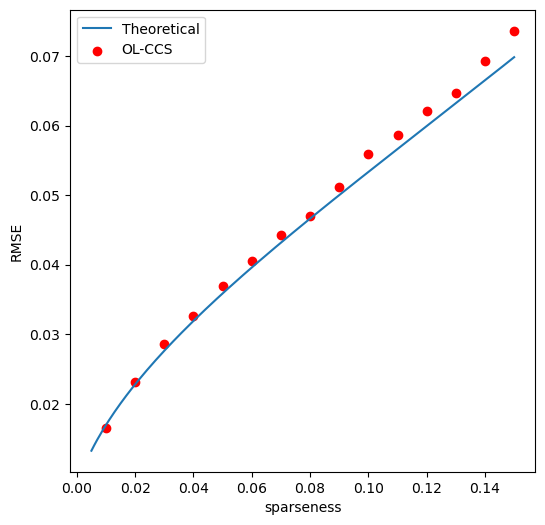

In [6]:
# Theoretical data import
theo = genfromtxt('stat018.csv', delimiter=',')

theoline = np.arange(0.005, 0.151, 0.001)
olccsline = np.arange(0.01, 0.16, 0.01)

plt.figure(figsize=(6, 6))
plt.plot(theoline,theo)
plt.scatter(olccsline,rmseArrALL, c="red")
plt.xlabel("sparseness")
plt.ylabel("RMSE")
plt.legend(['Theoretical', 'OL-CCS'])

## OL-CCS
# Open-Loop Coherent Compressed Sensor
# Author: M. D. Sudeera H. Gunathilaka

##BSD 3-Clause License

#Copyright (c) 2023, NTT Research Inc., PHI labs, algorithms

#Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

#1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

#2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

#3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

#THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.